In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, RegressorMixin

df = pd.read_excel("dataset.xlsx")
df.drop(columns=["Seli", "Tarih"], inplace=True, errors='ignore')

# mccinfo sütunundan dört haneli değeri çekmek için fonksiyon
def extract_mcc(value):
    if pd.isnull(value):
        return np.nan
    match = re.match(r"(\d{4})-", value)
    if match:
        return match.group(1)
    else:
        return np.nan

df['mccinfo'] = df['mccinfo'].apply(extract_mcc)
num_missing_mcc = df['mccinfo'].isnull().sum()
print(f"mccinfo değeri bulunamadığı için silinecek satır sayısı: {num_missing_mcc}")
df = df.dropna(subset=['mccinfo'])

# Sayısal sütunlardaki değerlerin düzenlenmesi
numeric_columns = [
    "bıst100_Kapanış", "bıst100_Açılış", "bıst100_Yüksek", "bıst100_Düşük",
    "Euro_Kapanış", "Euro_Açılış", "Euro_Yüksek", "Euro_Düşük",
    "USD_Kapanış", "USD_Açılış", "USD_Yüksek", "USD_Düşük",
]

def fix_numeric_value(s):
    s = s.replace(',', '.')
    if s.count('.') > 1:
        second_dot = s.find('.', s.find('.') + 1)
        s = s[:second_dot]
    return s

for col in numeric_columns:
    df[col] = df[col].astype(str).apply(fix_numeric_value)
    df[col] = df[col].astype(float)

# Kategorik sütunların kodlanması
categorical_columns = ["Şehir", "İlçe", "mccinfo"]
le = LabelEncoder()
for col in categorical_columns:
    df[col] = le.fit_transform(df[col])

# Hedef ve özniteliklerin ayrılması
target = "Tek Çekim Komisyon Oranı (Güncel)"
X = df.drop(columns=[target])
y = df[target]


mccinfo değeri bulunamadığı için silinecek satır sayısı: 15


In [2]:

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

n_clusters = 6 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Küme bilgilerini ölçeklendirilmiş veri setine ekliyoruz.
X_scaled['Cluster'] = clusters

print("Kümeleme işlemi tamamlandı. Küme dağılımı:")
print(pd.Series(clusters).value_counts())

Kümeleme işlemi tamamlandı. Küme dağılımı:
1    520
0    385
3    341
2    170
5    158
4    118
Name: count, dtype: int64


c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\yagiz\anaconda3\envs\img\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\yagiz\anaconda3\envs\img\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\yagiz\anaconda3\envs\img\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\yagiz\anaconda3\envs\img\lib\subprocess.py", line 1436, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
c

In [3]:
class ELMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_hidden=50, activation='sigmoid', random_state=42, reg_alpha=0.0):

        self.n_hidden = n_hidden
        self.activation = activation
        self.random_state = random_state
        self.reg_alpha = reg_alpha

    def _activation(self, x):
        if self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'tanh':
            return np.tanh(x)
        else:
            raise ValueError("Bilinmeyen aktivasyon fonksiyonu.")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        rng = np.random.RandomState(self.random_state)

        # Rastgele input ağırlıkları ve bias değerleri oluşturuluyor
        self.input_weights_ = rng.randn(n_features, self.n_hidden)
        self.bias_ = rng.randn(self.n_hidden)

        # Gizli katmanın çıktısı hesaplanıyor
        H = self._activation(np.dot(X, self.input_weights_) + self.bias_)

        # Ridge regularizasyon 
        if self.reg_alpha > 0:
            I = np.eye(H.shape[1])
            self.beta_ = np.linalg.inv(H.T.dot(H) + self.reg_alpha * I).dot(H.T).dot(y)
        else:
            self.beta_ = np.linalg.pinv(H).dot(y)
        return self

    def predict(self, X):
        H = self._activation(np.dot(X, self.input_weights_) + self.bias_)
        return np.dot(H, self.beta_)


In [4]:
all_predictions = pd.Series(index=y.index, dtype=float)
cluster_metrics = {}

for cluster in np.unique(clusters):
    print(f"\nCluster {cluster} için model eğitimi başlatılıyor...")
    # İlgili kümeye ait verileri seçip 'Cluster' sütununu çıkarıyoruz
    cluster_mask = X_scaled['Cluster'] == cluster
    X_cluster = X_scaled.loc[cluster_mask].drop(columns=['Cluster'])
    y_cluster = y.loc[cluster_mask]
    
    # Eğer örnek sayısı 10'dan azsa, CV kat sayısı örnek sayısına göre ayarlanıyor
    if len(X_cluster) < 10:
        print(f"Uyarı: Cluster {cluster} için örnek sayısı {len(X_cluster)}, CV kat sayısı örnek sayısına göre ayarlanıyor.")
        kf = KFold(n_splits=len(X_cluster), shuffle=True, random_state=124)
    else:
        kf = KFold(n_splits=10, shuffle=True, random_state=422)
    
    # Pipeline: sadece ELMRegressor kullanılıyor (özellik seçimi olmadan)
    pipeline = Pipeline([
        ('elm', ELMRegressor(n_hidden=25, activation='relu',reg_alpha=0.1 ,random_state=42))
    ])
    
    # Cross-validation ile tahminleri elde ediyoruz
    y_pred_cluster = cross_val_predict(pipeline, X_cluster, y_cluster, cv=kf)
    
    # Küme bazında performans metriklerini hesaplıyoruz
    mae = mean_absolute_error(y_cluster, y_pred_cluster)
    mape = mean_absolute_percentage_error(y_cluster, y_pred_cluster)
    r2 = r2_score(y_cluster, y_pred_cluster)
    
    # cluster_metrics[cluster] = {'MAE': mae, 'MAPE': mape, 'R2': r2}
    # print(f"Cluster {cluster} sonuçları:")
    # print(f"MAE: {mae:.4f}")
    # print(f"MAPE: {mape:.4f}")
    # print(f"R2: {r2:.4f}")
    
    # Bu kümedeki tahminleri orijinal indeksleriyle saklıyoruz
    all_predictions.loc[cluster_mask] = y_pred_cluster

print("\nTüm kümeler için model sonuçları:")
print(cluster_metrics)


overall_mae = mean_absolute_error(y, all_predictions)
overall_mape = mean_absolute_percentage_error(y, all_predictions)
overall_r2 = r2_score(y, all_predictions)

print("\nGenel model sonuçları:")
print(f"Genel MAE: {overall_mae:.4f}")
print(f"Genel MAPE: {overall_mape:.4f}")
print(f"Genel R2: {overall_r2:.4f}")





Cluster 0 için model eğitimi başlatılıyor...

Cluster 1 için model eğitimi başlatılıyor...

Cluster 2 için model eğitimi başlatılıyor...

Cluster 3 için model eğitimi başlatılıyor...

Cluster 4 için model eğitimi başlatılıyor...

Cluster 5 için model eğitimi başlatılıyor...

Tüm kümeler için model sonuçları:
{}

Genel model sonuçları:
Genel MAE: 0.5184
Genel MAPE: 0.1299
Genel R2: 0.1799


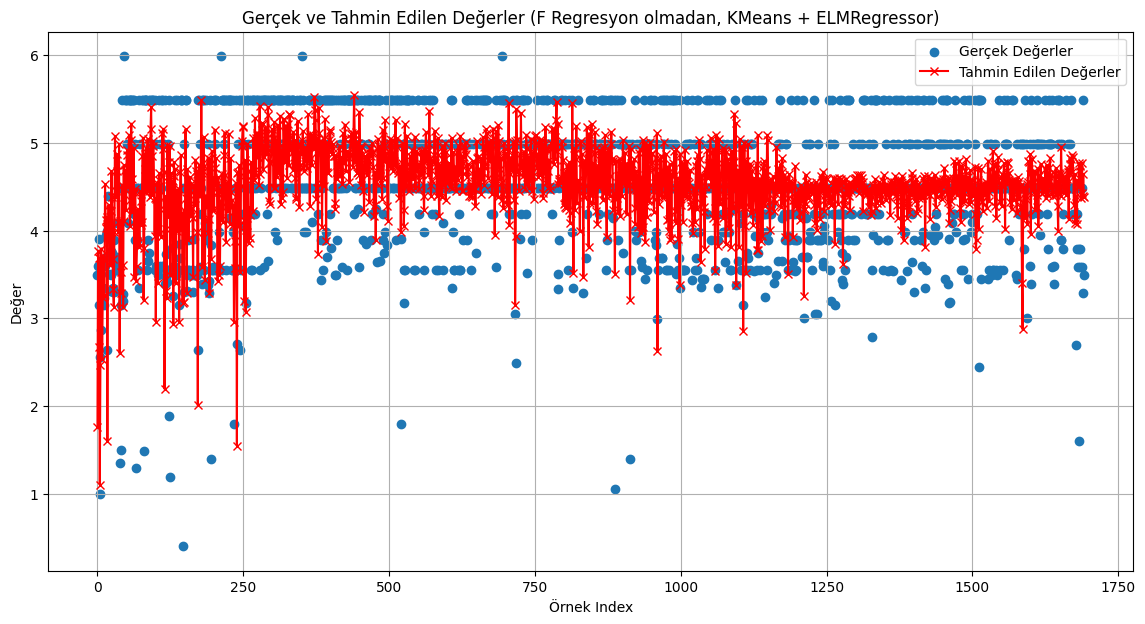

In [5]:

plt.figure(figsize=(14,7))
plt.scatter(np.arange(len(y)), y, label="Gerçek Değerler", marker="o")
plt.plot(np.arange(len(y)), all_predictions.sort_index(), label="Tahmin Edilen Değerler", marker="x", color="red", linestyle="-")
plt.xlabel("Örnek Index")
plt.ylabel("Değer")
plt.title("Gerçek ve Tahmin Edilen Değerler (F Regresyon olmadan, KMeans + ELMRegressor)")
plt.legend()
plt.grid(True)
plt.show()